In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='intra'

species='human'
SRP_name='aggregates'
resolution='1kbp_raw'

In [3]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [4]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
cat_list_genes = marker_table.index.tolist()

In [6]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [7]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [8]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())


In [9]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'type']

number_of_genes_list = [100]
marker_level_list = ['type']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/{marker_level}_markers_top1000.csv.gz', skiprows=1)

        marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/ensg_geneid_symbol.csv', sep='\t')[['Ensembl_gene_identifier', 'Symbol']]
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,15,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])

In [12]:
marker_list = marker_list.sample(frac=1)

In [13]:
df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]

df_gene_tp = df_gene_tp.fillna(0)

In [17]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [20]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [26]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:ylabel='Count'>

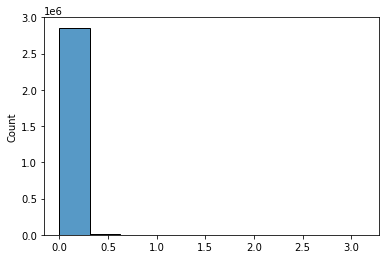

In [27]:
sns.histplot(all_bins_std , bins=10)

In [34]:
all_bins_mean.max()

0.2456568330526352

In [40]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_mean[all_bins_mean > 0.].index.tolist()]

#features = df_gene_tp_all_info_mean.loc[:, bin_random]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

In [41]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



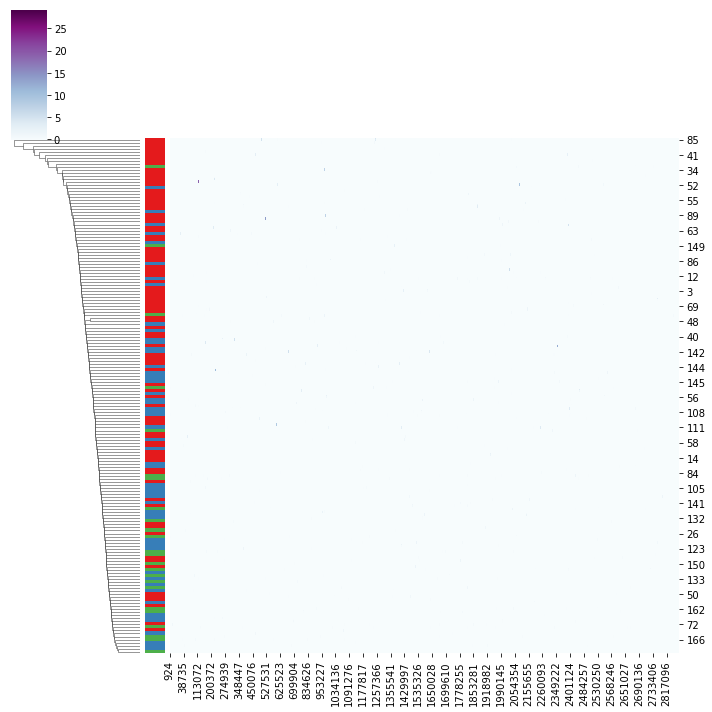

In [73]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 4]['bin_id'].tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



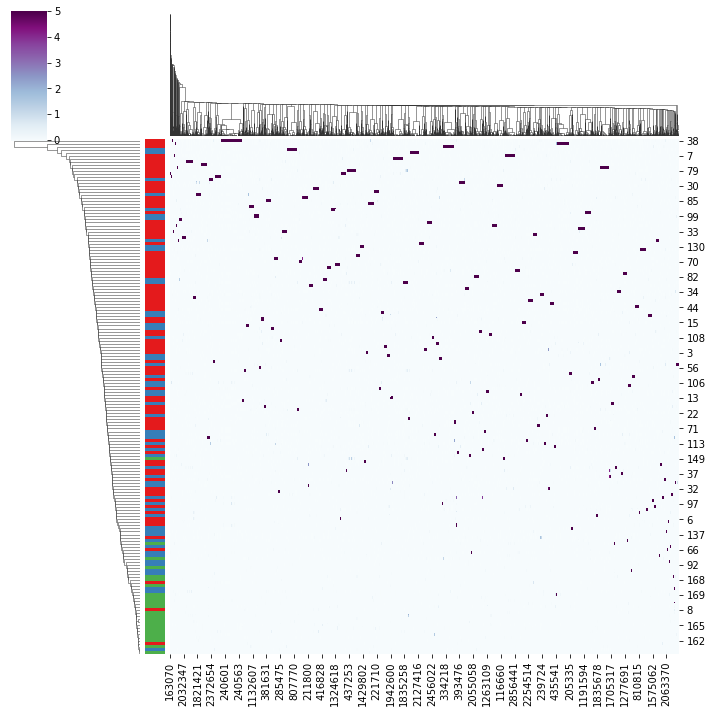

In [71]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.4].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, vmax=5)


In [64]:
all_bins_std.max()

3.128002166748047

In [56]:
all_bins_mean.max()

0.2456568330526352

In [14]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [15]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [16]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [42]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [42]:
marker_list_mouse = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [43]:
marker_list_mouse

group       cell_type  rank           gene  recurrence     auroc  \
0      L2/3 IT       L2/3 IT_1     1  6530403H02Rik           5  0.842734   
1      L2/3 IT       L2/3 IT_1     2        Adamts2           5  0.752062   
2      L2/3 IT       L2/3 IT_1     3        Col23a1           5  0.702306   
3      L2/3 IT       L2/3 IT_1     4            Met           5  0.702247   
4      L2/3 IT       L2/3 IT_1     5            Ust           5  0.696202   
...        ...             ...   ...            ...         ...       ...   
85995      Vip  Vip Serpinf1_3   996        Gm13031           0  0.594600   
85996      Vip  Vip Serpinf1_3   997        Tmem41a           0  0.594572   
85997      Vip  Vip Serpinf1_3   998           Wwp1           0  0.594570   
85998      Vip  Vip Serpinf1_3   999         Osbpl7           0  0.594559   
85999      Vip  Vip Serpinf1_3  1000          Xrcc5           0  0.594531   

       fold_change  fold_change_detection  expression  precision    recall  \
0         5.410202               2.606655  255.840030   0.095304  0.830882   
1         7.557666               4.621909   99.357999   0.152135  0.582932   
2        12.460411               7.980352   61.676311   0.219897  0.446298   
3         9.147210               6.442665   53.928589   0.201546  0.445979   
4         6.217147               3.645296   59.489654   0.121974  0.479271   
...            ...                    ...         ...        ...       ...   
85995     1.808722               1.339642    0.000000   0.055076  0.226728   
85996     0.824817               0.705201    0.000000   0.018392  0.324274   
85997     0.923881               0.698012    0.000000   0.029692  0.610828   
85998     1.114155               1.857670   20.178161   0.026148  0.361312   
85999     1.308560               1.175172    0.000000   0.041882  0.359141   

       population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0           492.833333           6    NaN  False   True   True    True   True   
1           492.833333           6    NaN  False   True   True    True   True   
2           492.833333           6    NaN  False   True   True    True   True   
3           492.833333           6    NaN  False   True   True    True   True   
4           492.833333           6    NaN  False   True   True    True   True   
...                ...         ...    ...    ...    ...    ...     ...    ...   
85995        45.000000           7  False  False  False  False   False  False   
85996        45.000000           7  False  False  False  False   False  False   
85997        45.000000           7  False  False  False  False   False  False   
85998        45.000000           7  False  False  False  False   False  False   
85999        45.000000           7  False  False  False  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
85995  False  
85996  False  
85997  False  
85998  False  
85999  False  

[86000 rows x 20 columns]

In [44]:
marker_list_t = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/human/subclass_markers_top1000.csv.gz', skiprows=1)

marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


marker_list_mouse = marker_list_mouse[['gene', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']])


In [50]:
marker_list_mouse.drop_duplicates('classt')

gene    group      cell_type         classt
0      6530403H02Rik  L2/3 IT      L2/3 IT_1  Glutamatergic
24000         Sorcs1    Lamp5  Lamp5 Egln3_1      GABAergic

In [47]:
marker_list_t

classt       group  rank          gene  recurrence     auroc  \
0          GABAergic  Chandelier     1  LOC101928964           8  0.985598   
1000       GABAergic       Lamp5     1     LINC00299           9  0.959632   
2000       GABAergic  Lamp5_Lhx6     1         CHST9           9  0.980043   
3000       GABAergic        Pax6     1        SORCS3           9  0.973046   
4000       GABAergic       Pvalb     1       CNTNAP3           9  0.902853   
5000       GABAergic        Sncg     1          CNR1           8  0.910402   
6000       GABAergic         Sst     1         GRIK1           9  0.955291   
7000       GABAergic   Sst Chodl     1           NPY           7  0.989269   
8000       GABAergic         Vip     1           VIP           9  0.924150   
9000   Glutamatergic     L2/3 IT     1          CUX2           9  0.928681   
10000  Glutamatergic       L4 IT     1  LOC101927874           9  0.888017   
11000  Glutamatergic       L5 ET     1         GRIK2           8  0.991095   
12000  Glutamatergic       L5 IT     1         CMTM8           9  0.735383   
13000  Glutamatergic     L5/6 NP     1       ZNF385D           9  0.997822   
14000  Glutamatergic       L6 CT     1      ADAMTSL1           9  0.985028   
15000  Glutamatergic       L6 IT     1          NFIA           8  0.916792   
16000  Glutamatergic  L6 IT Car3     1         RGS12           9  0.998601   
17000  Glutamatergic         L6b     1      KIAA1217           9  0.992582   
18000   Non-neuronal       Astro     1        ADGRV1           8  0.999169   
19000   Non-neuronal        Endo     1         ABCB1           6  0.989694   
20000   Non-neuronal   Micro-PVM     1         DOCK8           7  0.990340   
21000   Non-neuronal       Oligo     1           MBP           8  0.996898   
22000   Non-neuronal         OPC     1         CSMD1           7  0.999789   
23000   Non-neuronal        VLMC     1         LAMA2           5  0.961477   

       fold_change  fold_change_detection   expression  precision  ...  \
0        22.716047               2.402950   707.815600   0.038015  ...   
1000     11.184435               3.555593   254.549933   0.286739  ...   
2000     53.209179               7.442978   146.464573   0.355381  ...   
3000      7.053525               1.692281   290.667159   0.034813  ...   
4000      6.410934               2.550376    49.303167   0.438579  ...   
5000      5.720220               1.714736   318.352551   0.110595  ...   
6000      5.672309               1.127706  1448.233338   0.299948  ...   
7000    353.327164              15.563288  1166.518240   0.051553  ...   
8000     69.557074              23.363171   195.056119   0.839898  ...   
9000     11.191616               3.003808    84.809925   0.566082  ...   
10000     6.984786               2.540650    57.445000   0.341146  ...   
11000     5.517651               1.006303  1013.552073   0.004391  ...   
12000     6.220444               3.700134    11.506718   0.510243  ...   
13000    55.119050               1.581331   912.461122   0.058315  ...   
14000    13.510777               1.704467   341.272962   0.060786  ...   
15000     5.698901               2.917104    69.732355   0.232273  ...   
16000    26.377682               1.931117   274.739875   0.088500  ...   
17000    11.706484               1.211759   745.832397   0.046732  ...   
18000   211.429050              12.131286   994.118513   0.707302  ...   
19000   301.194413              31.072450   660.287466   0.396097  ...   
20000   169.343795              22.511913   408.761051   0.568703  ...   
21000    34.734555               2.852277   884.177547   0.635939  ...   
22000    36.323431               1.609777  1259.616100   0.235231  ...   
23000    22.195259               2.567045   946.514127   0.102894  ...   

       n_datasets  H200.1030_SSv4  H200.1025_SSv4  H200.1023_SSv4  \
0               9            True           False            True   
1000            9            True            True            True   
2000 